# Задание 1
Необходимо выяснить, какие пары товаров пользователи чаще всего покупают вместе, то есть найти паттерны покупок для оптимизации размещения продуктов в магазине, удобства пользователей и увеличения выручки.

In [1]:
import pandas as pd
import itertools
import numpy as np
import statsmodels.api as sm
import holidays
from fbprophet import Prophet
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from plotly.offline import iplot
import plotly.graph_objs as go
import pandahouse as ph
import warnings
warnings.filterwarnings('ignore')

In [2]:
purchases = pd.read_csv('test1_completed.csv')

In [3]:
purchases.head(10)

,id,Товар,Количество
0,17119,Лимон,1.10
1,17119,Лимон оранжевый,0.70
2,17119,Лук-порей,10.00
3,17119,Лук репчатый,2.50
4,17119,Малина свежая,1.00
5,17119,Морковь немытая,1.40
6,17119,Черешня сушеная,1.80
7,17530,Лимон оранжевый,0.25
8,17530,Изюм Султана,0.50
9,17530,Капуста цветная,2.00


In [4]:
# для решения нашей задачи колонка с количеством товаров не нужна, можно удалить её
purchases = purchases.drop(columns='Количество')

purchases = purchases.rename(columns={'Товар': 'product'})

In [5]:
# отсортируем товары в каждой покупке для дальнейшего составления одинаковых сочетаний 
purchases = purchases.sort_values(['id', 'product'])

In [6]:
# составим все возможные парные комбинации товаров в каждой покупке
purchases = purchases.groupby('id')['product'].apply(lambda row: pd.DataFrame.from_records(itertools.combinations(row, 2)))

In [7]:
purchases = purchases.value_counts().to_frame()

In [8]:
# оформим таблицу в соответствии с требуемым форматом ответа
purchases.index = purchases.index.set_names(['Товар_1', 'Товар_2'])
purchases = purchases.reset_index().rename(columns={0: 'Встречаемость'})

In [9]:
purchases.head(5)

,Товар_1,Товар_2,Встречаемость
0,Огурцы Луховицкие,Укроп,431
1,Петрушка,Укроп,408
2,Арбуз,Огурцы Луховицкие,345
3,Кабачки,Огурцы Луховицкие,326
4,Кинза,Укроп,303


# Задание 2
К вам поступила информация о числе заказов за прошедшие 3 месяца с разрешением по неделям.

Постройте (если это возможно) прогноз продаж на следующие 3 месяца, с учётом того, что в неделю с 2020-02-02 по 2020-02-09 была проведена массивная акция, повысившая число заказов на 7%

In [10]:
df = pd.read_csv('test2_completed.csv')
df

,Дата,Число заказов
0,2020-01-05,650
1,2020-01-12,837
2,2020-01-19,1020
3,2020-01-26,1176
4,2020-02-02,1489
5,2020-02-09,1823
6,2020-02-16,1991
7,2020-02-23,2166
8,2020-03-01,2334
9,2020-03-08,2607


In [11]:
df = df.rename(columns={'Дата': 'date',
               'Число заказов': 'quantity'})

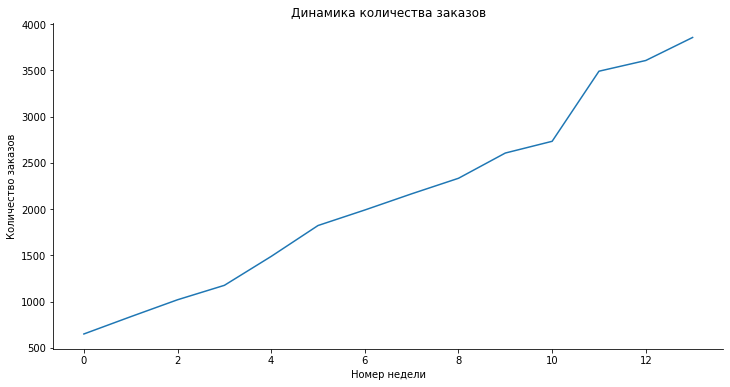

In [12]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df['quantity'])
plt.title('Динамика количества заказов')
plt.xlabel("Номер недели")
plt.ylabel("Количество заказов")
sns.despine()

Заметна довольно четкая линейная взаимосвязь, 22 марта виден скачок, скорее всего это связано с началом периода ковидной изоляции, в связи с чем люди стали активнее пользоваться онлайн магазинами.

При прогнозировании временных рядов необходимо учитывать несколько основных факторов, таких как:
1. Сезонность - годовая, недельная 
2. Тренд
3. Учет аномальных дней и событий, приведших к ним
4. А так же влияние других маркетинговых, производственных и т.д. факторов

В нашем распоряжении очень мало данных, имеющих довольно четкую линейную взаимосвязь, что чисто технически позволяет сформировать некоторый прогноз, но вряд ли его можно считать адекватным, можем получить что-нибудь такое :)

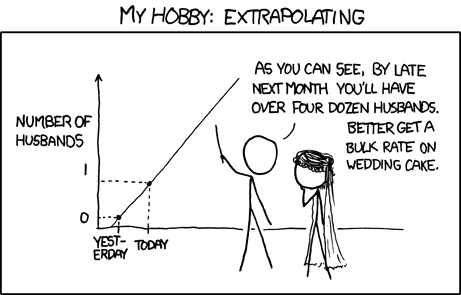


Для построения приемлемого прогноза хотелось бы располагать данными хотя бы за 1 год, позволяющими учесть влияние годовой сезонности, праздников и других событий. 

Здесь же мы можем отталкиваться только от линии тренда, так как даже разбивки по дням - для того чтобы учесть внутринедельную сезонность - у нас нет.

Попробуем построить прогноз на этих данных спомощью линейной регрессии.

Поскольку дата возрастает через равные недельные промежутки, для удобства можем заменить её на порядковый номер недели.

In [13]:
df['x'] = df.index+1

По условию с 2020-02-02 по 2020-02-09 была проведена акция, повысившая число заказов на 7%, чтобы учесть этот момент, рассчитаем количество заказов без проведения этой акции и передадим скорректированное значение модели линейной регрессии.

In [14]:
quantity_of_orders = round(1823/1.07)

In [15]:
df.at[5, 'quantity'] = quantity_of_orders

In [16]:
Y = df.quantity
X = df.x

In [17]:
X = sm.add_constant(X)
reg = sm.OLS(Y, X)
model_reg = reg.fit()
print(model_reg.summary())

                            OLS Regression Results                            
Dep. Variable:               quantity   R-squared:                       0.983
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     688.2
Date:                Tue, 26 Oct 2021   Prob (F-statistic):           5.76e-12
Time:                        07:45:46   Log-Likelihood:                -88.243
No. Observations:                  14   AIC:                             180.5
Df Residuals:                      12   BIC:                             181.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        256.6044     80.595      3.184      0.0

Показатель R<sup>2</sup>  говорит о том, что около 98% изменчивости данных объясняются данной моделью, полученный коэффициент при х говорит о том, что с каждой последующей неделей количество заказов в среднем будет увеличиваться на 248 (95%-й доверительный интервал 227-268).

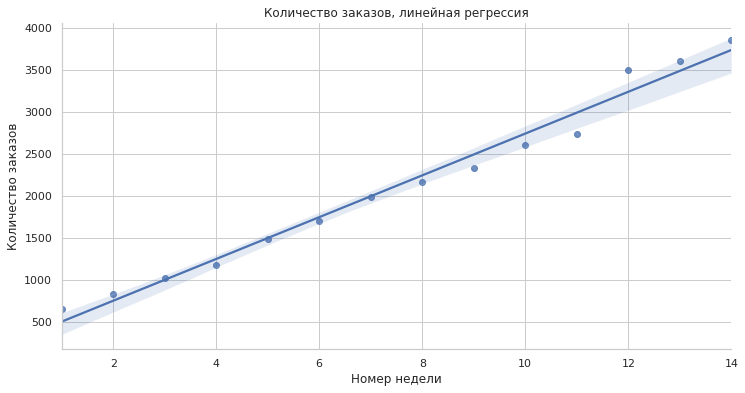

In [18]:
sns.set(style='whitegrid', rc={'figure.figsize' : (12,6)})
sns.regplot(x = 'x', y = 'quantity', data = df)

plt.title('Количество заказов, линейная регрессия')
plt.xlabel("Номер недели")
plt.ylabel("Количество заказов")
sns.despine()

Рассчитаем ошибку модели.

In [19]:
df['y_pred'] = model_reg.predict(X)

In [20]:
df['e'] = df['quantity'] - df['y_pred']
df['p'] = 100 * df['e'] / df['quantity']
print('MAPE (средняя абсолютная ошибка в процентах) – ', round(np.mean(abs(df['p'])), 1), '%')
print('MAE (средняя абсолютная ошибка) – ', round(np.mean(abs(df['e']))))

MAPE (средняя абсолютная ошибка в процентах) –  5.9 %
MAE (средняя абсолютная ошибка) –  107


Средняя ошибка модели меньше 6%, сформируем с её помощью прогноз на следующие три месяца.

In [21]:
x_new = pd.Series(np.array(range(15, 29)))
x_new = sm.add_constant(x_new)
y_new = round(model_reg.predict(x_new), 2)

final_df = pd.DataFrame({'date': pd.date_range(start='2020/04/12', end='2020/07/12', freq='W'), 'quantity': y_new})

In [22]:
df = df[['date', 'quantity']]

final_df['date'] = final_df['date'].astype(str)
final_df = df.append(final_df).reset_index().drop(columns=['index'])

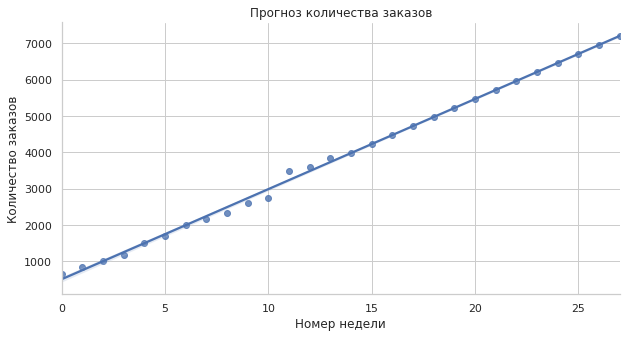

In [23]:
sns.set(style='whitegrid', rc={'figure.figsize' : (10,5)})
sns.regplot(x = final_df.index, y = 'quantity', data = final_df)

plt.title('Прогноз количества заказов')
plt.xlabel("Номер недели")
plt.ylabel("Количество заказов")
sns.despine()

In [24]:
final_df[14:]

,date,quantity
14,2020-04-12,3981.25
15,2020-04-19,4229.56
16,2020-04-26,4477.87
17,2020-05-03,4726.18
18,2020-05-10,4974.49
19,2020-05-17,5222.80
20,2020-05-24,5471.11
21,2020-05-31,5719.42
22,2020-06-07,5967.73
23,2020-06-14,6216.04


Мы получили прогноз на следующие 14 недель, который учитывает общий тренд наших данных без учета  

Имея в распоряжении бОльшее количество данных и возможность учесть факторы недельной и годовой сезонности, цикличности, праздников, маркетинговых мероприятий, уровня цен и других, можно лучше понять их структуру, устойчивость и составлять надежные прогнозы.

# Задание 3

В базе данных вашей компании присутствуют следующие таблицы

**city**
* city_id – id города, где проходит акция
* client_city_id – id города, где находится покупатель
* city – город
* client_city – город, где находится покупатель

**client**
* client_id – id покупателя
* client_city_id – id города, где находится покупатель
* birth_date – дата рождения покупателя
* registration – дата регистрации покупателя

**promotion**
* promotion_id – id акции
* category_id – id категории
* promotion_name – акция
* category_name – категория
* partner_id – id партнёра
* partner_name – партнёр

**purchase**
* purchase_id – id покупки
* partner_id – id партнёра
* client_id – id покупателя
* city_id – id города
* promotion_id – id акции
* category_id – id категории
* purchase_date – дата покупки
* price – цена за единицу товара
* quantity – число проданных единиц
* status – статус покупки

Вам нужно написать запрос, чтобы получить такую таблицу

* purchase_date – дата покупки
* purchase_id – id покупки
* client_id – id покупателя
* client_age – возраст покупателя
* client_registration_age – как долго человек пользуется вашими магазинами
* client_category – содержит new или old, если это первая или последующая покупка соответственно
* promotion_name – акция
* category_name – категория
* partner_name – партнёр
* client_city – город, где находится покупатель
* city – город
* revenue – сумма выручки
* quantity – число проданных единиц

При этом в таблице должны присутствовать только значения, где в поле **status** стоит значение 1, и только те, где **purchase_date** находится в диапазоне от 01.05.2020 до 01.08.2020

In [25]:
connection = dict(database='default',
                  host='https://clickhouse.lab.karpov.courses',
                  user='*****',
                  password='*****')

In [26]:
query = """
SELECT 
    purchase_date,
    purchase_id,
    purchase.client_id AS client_id,
    dateDiff('year', birth_date, purchase_date) AS client_age,
    dateDiff('month', registration, purchase_date) AS client_registration_age,
    CASE 
        WHEN purchase_date = min_date THEN 'new'
        ELSE 'old'
    END AS client_category,
    promotion_name,
    category_name,
    partner_name,
    client_city,
    city,
    toFloat32(quantity*price) AS renvenue,
    toFloat32(quantity) AS quantity
FROM 
    project_variant_2.purchase
    INNER JOIN project_variant_2.client ON client.client_id = purchase.client_id
    INNER JOIN project_variant_2.city ON city.city_id = purchase.city_id AND city.client_city_id = client.client_city_id
    INNER JOIN (SELECT promotion_id,
                      promotion_name
                FROM project_variant_2.promotion) promo ON promo.promotion_id = purchase.promotion_id
    INNER JOIN (SELECT category_id,
                      category_name
                FROM project_variant_2.promotion) category ON category.category_id = purchase.category_id 
    INNER JOIN (SELECT partner_id,
                      partner_name
                FROM project_variant_2.promotion) partner ON partner.partner_id = purchase.partner_id
    INNER JOIN (SELECT
                    client_id,
                    min(purchase_date) AS min_date
                FROM project_variant_2.purchase
                WHERE status == 1
                GROUP BY client_id)  AS r ON r.client_id = purchase.client_id
WHERE status == 1 AND purchase_date >= '2020-05-01' AND purchase_date < '2020-08-01'
"""

In [27]:
data = ph.read_clickhouse(query, connection=connection)
data.head(10)

,purchase_date,purchase_id,client_id,client_age,client_registration_age,client_category,promotion_name,category_name,partner_name,client_city,city,renvenue,quantity
0,2020-06-05,0,853,28,12,old,campaign_2,Фрукты,Всем партнёрам партнёр,Ярославль,Киев,150.0,5.0
1,2020-06-15,1,406,23,8,old,campaign_4,Прочее,Всем партнёрам партнёр,Минск,Новгород,1150.0,5.0
2,2020-07-16,15,109,29,20,old,campaign_4,Прочее,"ООО Ширяева, Хохлова и Тимофеева",Щучинщина,Санкт-Петербург,440.0,8.0
3,2020-05-18,26,10,20,6,old,campaign_4,Прочее,KarpovCourses,Ярославль,Санкт-Петербург,570.0,2.0
4,2020-07-07,27,366,26,12,old,campaign_2,Фрукты,KarpovCourses,Казань,Казань,880.0,4.0
5,2020-07-08,33,77,23,6,old,campaign_2,Фрукты,KarpovCourses,Вена,Минск,555.0,3.0
6,2020-05-29,38,46,30,16,old,campaign_2,Фрукты,KarpovCourses,Москва,Москва,2820.0,6.0
7,2020-06-04,44,881,27,4,old,campaign_1,Бакалея,KarpovCourses,Вена,Новгород,1530.0,6.0
8,2020-05-17,47,945,24,8,old,campaign_3,Овощи,Всем партнёрам партнёр,Казань,Казань,680.0,4.0
9,2020-06-01,50,901,22,16,old,campaign_2,Фрукты,KarpovCourses,Санкт-Петербург,Минск,165.0,1.0
